<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Hyperparameters, GridSearch, and Pipelines

_Authors: Kiefer Katovich, David Yerrington, Matt Brems, Noelle Brown_

---

![](https://snag.gy/aYcCt2.jpg)

### Learning Objectives
- Describe what the terms hyperparameters, GridSearch, and pipeline mean.
- Apply `sklearn`'s `GridSearchCV` object.
- Use attributes of the GridSearch object.
- Describe the pitfalls of searching large hyperparameter spaces.
- Build pipelines.

In [1]:
# traditional mandate of imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [2]:
# Read in data.
data = pd.read_csv('../data/UNdata.csv')
print(data.shape)
# Examine first five rows.
data.head()

(188, 6)


,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
0,Afghanistan,Asia,45.0,46.0,154,2848
1,Albania,Europe,68.0,74.0,32,863
2,Algeria,Africa,67.5,70.3,44,1531
3,Angola,Africa,44.9,48.1,124,355
4,Argentina,America,69.6,76.8,22,8055


## United Nations Data
Understanding the dataset:
- `country`: the name of the nation
- `region`: the region of the world (Africa, America, Asia, Europe, Oceania)
- `lifeMale`: the life expectancy of males
- `lifeFemale`: the life expectancy of females
- `infantMortality`: the infant mortality rate (generally reported per 1,000 live births)
- `GDPperCapita`: the Gross Domestic Product per person

In [3]:
# Check for missing values & data types.--> verified to be all good!
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          188 non-null    object 
 1   region           188 non-null    object 
 2   lifeMale         188 non-null    float64
 3   lifeFemale       188 non-null    float64
 4   infantMortality  188 non-null    int64  
 5   GDPperCapita     188 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 8.9+ KB


In [4]:
# Set country to be the index. (we'll see why we are doing this later, further down)
data.set_index('country', inplace = True)
data.head() # we see the output replaces the numerical indices with country col

,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
country,,,,,
Afghanistan,Asia,45.0,46.0,154,2848
Albania,Europe,68.0,74.0,32,863
Algeria,Africa,67.5,70.3,44,1531
Angola,Africa,44.9,48.1,124,355
Argentina,America,69.6,76.8,22,8055


In [5]:
# Dummy the other categorical variable: region.
data = pd.get_dummies(data, columns=['region'], drop_first=True)
data.head()

,lifeMale,lifeFemale,infantMortality,GDPperCapita,region_America,region_Asia,region_Europe,region_Oceania
country,,,,,,,,
Afghanistan,45.0,46.0,154,2848,0,1,0,0
Albania,68.0,74.0,32,863,0,0,1,0
Algeria,67.5,70.3,44,1531,0,0,0,0
Angola,44.9,48.1,124,355,0,0,0,0
Argentina,69.6,76.8,22,8055,1,0,0,0


<details><summary>What is our reference category for this dummy variable?</summary>

- Africa!
- There is no dummy variable for Africa in our data, meaning that all dummy variables would be interpreted **relative to Africa**.
</details>

### Create $Y$ variable
- Let's formulate our problem as trying to predict where females have higher life expectancy than males

In [6]:
# Create a column with 1 if the female life expectancy is greater
# than the male life expectancy otherwise 0
data['females_are_strong_as_hell'] = (data['lifeFemale'] > data['lifeMale']).astype(int)
data.head(2)
# The column name is a reference to the 
# Netflix series "The Unbreakable Kimmy Schmidt."

,lifeMale,lifeFemale,infantMortality,GDPperCapita,region_America,region_Asia,region_Europe,region_Oceania,females_are_strong_as_hell
country,,,,,,,,,
Afghanistan,45.0,46.0,154,2848,0,1,0,0,1
Albania,68.0,74.0,32,863,0,0,1,0,1


In [7]:
# by doing the .astype(int), we are making use of the True=integer 1 property in Python
(data['lifeFemale'] > data['lifeMale']).head(2)

country
Afghanistan    True
Albania        True
dtype: bool

In [8]:
# What should we check next?
data['females_are_strong_as_hell'].value_counts(normalize=True)

1    0.989362
0    0.010638
Name: females_are_strong_as_hell, dtype: float64

<details><summary>Do you have any concerns about the above?</summary>
    
- Our classes are severely <b>unbalanced</b>.<br>
- We should check out our tools for handling unbalanced classes. (e.g. moving our classification threshold, implement stratified $k$-fold cross-validation)<br>
- Given the relatively low sample size and the small number of the observations in the minority category here, it is unlikely that our model would be able to predict that a nation has a higher male life expectancy.
</details>

In [9]:
# Create a column with 1 if the female life expectancy is 5,
# or more years longer than the male life expectancy.
data['females_are_strong_as_hell'] = (data['lifeFemale'] >= (data['lifeMale'] + 5)).astype(int)

# Check the class balance now.
data['females_are_strong_as_hell'].value_counts(normalize=True)

0    0.569149
1    0.430851
Name: females_are_strong_as_hell, dtype: float64

**Modified Task: We are interested in predicting whether or not the female life expectancy of a nation is _at least five years_ greater than the male life expectancy.** This is a classification problem.

### Create the training and testing data

In [10]:
# Set up X and y.
X = data.drop(['females_are_strong_as_hell', 'lifeMale', 'lifeFemale'], axis = 'columns') # axis = 1 or 'columns', drops cols
y = data['females_are_strong_as_hell']

In [11]:
# Split our data into training and testing sets.
# set a custom test size of 33% for model evaluation. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [12]:
# What did stratify = y do? --> replicates similar distribution of the classes pre-train/test split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.568
1    0.432
Name: females_are_strong_as_hell, dtype: float64
0    0.571429
1    0.428571
Name: females_are_strong_as_hell, dtype: float64


<details><summary>Before we build a k-Nearest Neighbors model, what do we need to do? Why?</summary>
    
- <b>Standardize</b> our data! <br>
- If we *don't* standardize our data, then features that have larger spreads (e.g. higher ranges or higher standard deviations) will have a disproportionate influence on our model.<br>
- If all of your variables are already on the same scale, then scaling is not necessary.
</details>

In [13]:
# Instantiate.
ss = StandardScaler()

# Fit and transform train.
X_train_sc = ss.fit_transform(X_train)

# Transform test.
X_test_sc = ss.transform(X_test)

## Fit the Default kNN

Below we fit a default `KNeighborsClassifier` to predict `y`. ([Here is the documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))

<details><summary>What is the default number of neighbors used in kNN?</summary>
    
    - 5. (stated in the sklearn documentation)
</details>

In [14]:
# Instantiate.
knn = KNeighborsClassifier()

# Fit on train.
knn.fit(X_train_sc, y_train)

KNeighborsClassifier()

In [15]:
# Evaluate (predict and return 'accuracy' score).
knn.score(X_test_sc, y_test)

0.7619047619047619

<details><summary>What score is this?</summary>

- The default score: Accuracy. Calculated as the number of correct predictions / total predictions
</details>

In [16]:
# Evaluate against the baseline.
y_test.value_counts(normalize=True)

0    0.571429
1    0.428571
Name: females_are_strong_as_hell, dtype: float64

**As a general note of caution:** typically, when dealing with datasets with imbanced response classes, `Accuracy` may not be the best metric to make model conclusions. Because we might have a highly accurate model with more `True Negatives`, but less `True Positives`. We are aiming usually to have higher `True Positives` or `class 1` accurate predictions.

<details><summary>On the other hand, let's think if selecting the default number of neighbors: $k$ = 5 a good choice? Is it the best choice?</summary>

- We don't know!
- $k$ is a hyperparameter.
</details>

## What are "hyperparameters?"

Models often have **built-in quantities** that we can use to ***fine-tune our results***. Like: 
- What value of $k$ do we select?
- What distance metric do we select?
- Do we use LASSO or Ridge regularization?
- What value of $\alpha$ or $C$ do we use?

These are quantities our model **cannot learn**...but they **influence** the way our model learns and we as Data Scientists can **decide on these ourselves** to better our model! _(Though, it is worth noting that with the advancements in machine learning, there are now several **Automated Machine Learning** libraries, like [Pycaret](https://pycaret.org/classification1/) that take care of everything including hyperparameter tuning.)_

> These are different from statistical parameters, which are quantities a model _can_ learn.

However, different values for hyperparameters can result in substantially different models. 
- Here's a reference resource to [visualize fits for different values of $k$: Fig 5](http://scott.fortmann-roe.com/docs/BiasVariance.html) in $k$-nearest neighbors.

<details><summary>We want to find the optimal values for our hyperparameters. How do you think we might do this?</summary>

- Try many different values of hyperparameters and see which one performs the best on our data.
</details>

## Searching for the Best Hyperparameters

Our default kNN performs quite poorly on the test data. But what if we changed the number of neighbors? The weighting? The distance metric?

These are all hyperparameters of kNN. How would we do this manually? We would need to evaluate on the training data the set of hyperparameters that perform best, and then use that set of hyperparameters to fit the final model and score on the testing set.

**One method of searching for the optimal set of hyperparameters is called _GridSearching_.**

GridSearching gets its name from the fact that we are searching over a **"grid" of hyperparameters**. For example, imagine the `n_neighbors` hyperparameter as the columns and `weights` hyperparameter as the rows. This makes a grid. We check the accuracy for all combinations of hyperparameters on the grid.

[Where:](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) 

`n_neighbors`--> no. of nearest neighboring data points to consider based on Euclidean distance

`weights`--> weightage to assign for nearest neighboring data points
- uniform (default): assign equal weightage to all points
- distance: higher weightage for closer points

![](../images/grid.jpg)

### Using `GridSearchCV`

This would be an annoying process to have to do manually. Luckily `sklearn` comes in handy:

```python
from sklearn.model_selection import GridSearchCV
```

The `GridSearchCV` has a handful of important arguments:

| Argument | Description |
| --- | ---|
| **`estimator`** | The sklearn instance of the model to fit on |
| **`param_grid`** | A dictionary where keys are hyperparameters for the model and values are lists of values to test |
| **`cv`** | The number of internal cross-validation folds to run for each set of hyperparameters |
| **`n_jobs`** | How many cores to use on your computer to run the folds (-1 means use all cores) |
| **`verbose`** | How much output to display (0 is none, 1 is limited, 2 is printouts for every internal fit) |


Below is an example for how one might set up the GridSearch for our kNN:

```python
# declaring the param_grid:
knn_parameters = {
    'n_neighbors':[2,3], # test for 2 & 3 neighbouring data points
    'weights':['uniform','distance'], # test for uniform & distance weights
    'p':[1,2] # test distance metric: manhattan & euclidean
}
# instantiate and fit:
knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_gridsearcher.fit(X_train, y_train)
```

- The above code will run KNN with all the below combinations to find the best combination.
- As you can see it it comprehensive, running all possible combinations of the parameters we chose.

| n_neighbors | weights | p |
| :---: | :---: | :---: |
| 2 | 'uniform' | 1 |
| 2 | 'uniform' | 2 |
| 2 | 'distance' | 1 |
| 2 | 'distance' | 2 |
| 3 | 'uniform' | 1 |
| 3 | 'uniform' | 2 |
| 3 | 'distance' | 1 |
| 3 | 'distance' | 2 |

**Try out the `sklearn` GridSearch below on the training data.** 

[GridSearchCV documentation for additional reference](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [17]:
# Create dictionary of hyperparameters (param_grid).
# The keys MUST match the names of the estimator's arguments!
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}

In [18]:
# search using these number of neighbors:
list(range(1, 51, 10))

[1, 11, 21, 31, 41]

In [19]:
# Instantiate our GridSearchCV object.
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), # What is the model we want to fit?
                              knn_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1,
                              n_jobs=-1 # Use all CPU cores on your computer to speed up the fit
                             )

In [20]:
# Fit the GridSearchCV object to the data
# After the fit is completed, running score or predict will automatically choose the best model
knn_gridsearch.fit(X_train_sc, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


### Examining the Results of the GridSearch

Once the GridSearch has fit (this can take awhile!) we can pull out a variety of information and useful objects from the GridSearch object, stored as attributes:

| Property | Description |
| --- | ---|
| **`results.param_grid`** | Displays hyperparameters searched over. |
| **`results.best_score_`** | Best mean cross-validated score achieved. |
| **`results.best_estimator_`** | Reference to model with best score.  Is usable / callable. |
| **`results.best_params_`** | The hyperparameters that have been found to perform with the best score. |
| **`results.grid_scores_`** | Display score attributes with corresponding hyperparameters. | 

In [21]:
# Print out the score
# from documentation: Mean cross-validated score of the best_estimator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

knn_gridsearch.best_score_

0.784

In [22]:
# Print out the set of hyperparameters that achieved the best score.
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 1}

In [23]:
# Evaluate the best fit model on the test data.
# Best model is automatically chosen
knn_gridsearch.score(X_test_sc, y_test)

0.7619047619047619

In this case, we don't see any difference when we finally check the 'Accuracy' score on the test dataset vs what we had previously using the default n_neighbors (5).

**Let's see everything!**

In [24]:
knn_gridsearch.cv_results_

{'mean_fit_time': array([0.00188875, 0.0020524 , 0.00126815, 0.00119066, 0.00109744,
        0.00111513, 0.00107279, 0.00106249, 0.00104928, 0.00088849]),
 'std_fit_time': array([5.18221459e-04, 5.46642624e-04, 1.81948026e-04, 6.42151132e-05,
        4.32018149e-05, 9.57829721e-05, 3.49025908e-05, 1.10427868e-04,
        1.52939005e-04, 1.07625706e-04]),
 'mean_score_time': array([0.0026648 , 0.00343938, 0.00368505, 0.00236712, 0.00336862,
        0.00206699, 0.00214744, 0.00205722, 0.00215783, 0.0017406 ]),
 'std_score_time': array([2.28214633e-04, 8.67339310e-04, 2.49722724e-03, 1.95783530e-04,
        2.28937228e-03, 8.63148491e-05, 1.72248142e-04, 2.89196984e-04,
        2.60723404e-04, 3.28052342e-04]),
 'param_metric': masked_array(data=['euclidean', 'euclidean', 'euclidean', 'euclidean',
                    'euclidean', 'manhattan', 'manhattan', 'manhattan',
                    'manhattan', 'manhattan'],
              mask=[False, False, False, False, False, False, False, False,

In [25]:
# converting above to dataframe format and sorting best model first, viewing top 5
pd.DataFrame(knn_gridsearch.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001889,0.000518,0.002665,0.000228,euclidean,1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.76,0.84,0.92,0.72,0.68,0.784,0.086163,1
2,0.001268,0.000182,0.003685,0.002497,euclidean,21,"{'metric': 'euclidean', 'n_neighbors': 21}",0.84,0.84,0.76,0.72,0.72,0.776,0.054259,2
5,0.001115,0.000096,0.002067,0.000086,manhattan,1,"{'metric': 'manhattan', 'n_neighbors': 1}",0.76,0.84,0.92,0.72,0.64,0.776,0.096664,2
7,0.001062,0.000110,0.002057,0.000289,manhattan,21,"{'metric': 'manhattan', 'n_neighbors': 21}",0.84,0.84,0.76,0.72,0.72,0.776,0.054259,2
6,0.001073,0.000035,0.002147,0.000172,manhattan,11,"{'metric': 'manhattan', 'n_neighbors': 11}",0.84,0.84,0.68,0.64,0.68,0.736,0.086163,5


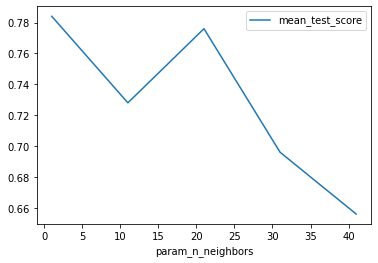

In [26]:
# visualising effect from increasing number of neighbors vs model accuracy
gs_df = pd.DataFrame(knn_gridsearch.cv_results_)
gs_df = gs_df[gs_df['param_metric'] == 'euclidean']
gs_df.plot(x='param_n_neighbors', y='mean_test_score');

We see that the model score drops as the number of neighbors increase - so it is not a good idea to have significantly large n_neighbors.

## A Word of Caution on GridSearching

`sklearn` models often have many hyperparameters with many different possible values. It may be tempting to search over a wide variety of them. In general, this is not wise.

<details><summary>Why not?</summary>

- Remember that GridSearch searches over **all possible combinations of hyperparameters in the parameter dictionary!**
    - In the previous GridSearch we just completed, the search happened using a combination of each number of neighbor from the range: [1, 11, 21, 31, 41] + changing distance metric between euclidean and manhattan, that is for neighbor:distance - 1,11,21,31,41:euclidean and 1,11,21,31,41:manhattan
        - total search count: number of items in the neighbors * number of items in weights = 5 * 2 = 10.

Imagine a more complex parameter dictionary as described here:

```python
parameter_grid = {
    'n_neighbors': range(1, 151),
    'weights': ['uniform', 'distance', custom_function],
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'leaf_size': range(1, 152),
    'metric': ['minkowski', 'euclidean'],
    'p': [1, 2]
}
```

**How many different combinations will need to be tested?**

| Parameter | Number of Chosen Values |
| --- | --- |
| **n_neighbors** | 150 |
| **weights** | 3 |
| **algorithm** | 4 |
| **leaf_size** | 151 |
| **metric** | 2 |
| **p** | 2 |
| <br>_150 \* 3 \* 4 \* 151 \* 2 \* 2 = n combinations_ <br><br>| _1,087,200_ |

If we select `cv = 5`, we would fit 1,087,200 models on five folds, meaning we fit 5,436,000 models!

If you're not careful, GridSearching can quickly scale out of hand computationally.

> **It is extremely important to understand what the hyperparameters do and think critically about what <i>ranges</i> are useful and relevant to your model!**
</details>

## A brief detour: estimators and transformers.
**Estimators** and **transformers** are two types of ***classes*** in `sklearn`.

We've seen several examples of each so far.

### Scikit-Learn _Estimators_
**Estimators** are essentially _models_. They fit this format:

```python
# Instantiate.
model = LinearRegression(params)
# Fit.
model.fit(X_train, y_train)
# Predict.
y_pred = model.predict(X_test)
```

Estimators have a **fit** and **predict** method.

### Scikit-Learn _Transformers_
**Transformers** are _not models_. They _transform your data_ using similar syntax to estimators. They work like this:

```python
# Instantiate.
ss = StandardScaler(params)
# Fit.
ss.fit(X_train)
# Transform.
X_transformed = ss.transform(X_train)
```

Instead of `fit` and `predict`, they have **fit** and **transform** methods. In fact, since you fit and transform together so often, they have a shortcut:

```python
ss = StandardScaler(params)
X_transformed = ss.fit_transform(X_train)
```

We've seen a few transformers, including `StandardScaler()` and `PolynomialFeatures()`. There's also `OneHotEncoder()` for dummy encoding and `LabelEncoder()` for factorizing variables. Later we'll see `PCA()`, which is also a transformer.

### Why is this relevant?

Previously, we applied GridSearch over the kNN Estimator. 

Check out the [StandardScaler documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Transformers may have hyperparameters as well - **but we can't GridSearch over a transformer**! There's no way to get an accuracy (or other) score from just a transformer, since a ***transformer can't predict***!

![](../images/grid.jpg)

In addition, the acronym ETL, meaning "extract, transform, load," is a very common one in data science. When we gather data from one or more places, there might be **a lot** of preprocessing going on.

Oftentimes, we'll want to apply several transformations to a dataset to standardize all data, *then* build a model. 
- If you do all of these preprocessing steps independently, your code can be messy and it'll be prone to errors!
- It can be challenging to consistently recreate this process.

## Pipelines
![](../images/pipe.png)

Pipelines will allow us to do two things:
1. Chain **many transformers together** with a final estimator.
2. Allow us to **GridSearch over a transformer's** hyperparameters.

- I personally love sklearn's Pipeline and use them a lot in my code.
- It helps keep your code neat and organized and allows hyperparameter searches over transformations as well!

[sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [27]:
# Instantiate a StandardScaler + kNN pipeline.
pipe = Pipeline([
    ('ss', StandardScaler()), # step1: transformation, we're assigning a string 'ss' to associate with scaling
    ('knn', KNeighborsClassifier()) # step2: estimation, we're assigning a string 'knn' to associate with knn model
])

In [28]:
# Fit estimator after applying transformations.
pipe.fit(X_train, y_train) # notice how we no longer need to fit with X_train_sc since the transformation happ in pipeline

Pipeline(steps=[('ss', StandardScaler()), ('knn', KNeighborsClassifier())])

In [29]:
# Evaluate. --> the result is the same as we saw way above with default kNN initiation
pipe.score(X_test, y_test)

0.7619047619047619

In [30]:
# Get params - Get parameters for this estimator. yes, you can GridSearchCV over these!
# Notice the naming convention of pipe arguments. similar to GridSearchCV we did above
pipe.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [31]:
# Instantiate a 2nd pipeline object.
pipe_2 = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

[sklearn standard scalar documentation for recap](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [32]:
# Define dictionary of hyperparameters.
pipe_2_params = {'ss__with_mean': [True, False], # iterating over 'how' scaling is done
                 'ss__with_std': [True, False], # iterating over 'how' scaling is done
                 'knn__p': [1, 2], # iterating over knn distance metric types
                 'knn__weights': ['uniform', 'distance'], # iterating over weightage based on distance
                 'knn__n_neighbors': [3, 5, 10]} # iterating over number of neighbors

#### Recap GridSearchCV instantiation we did previously:
```python
# instantiate:
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), # What is the model we want to fit?
                              knn_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1)
```

In [33]:
# Instantiate our GridSearchCV object.
pipe_2_gridsearch = GridSearchCV(pipe_2, # What is the model we want to fit?
                                 pipe_2_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1)

In [34]:
# Fit the GridSearchCV object to the data.
pipe_2_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [35]:
# Print out best score.
# from documentation: Mean cross-validated score of the best_estimator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

pipe_2_gridsearch.best_score_

0.768

In [36]:
# Print out best estimator.
pipe_2_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])

In [37]:
# Evaluate the best model on the test data.
pipe_2_gridsearch.score(X_test, y_test)

0.746031746031746

<details><summary>What would you conclude from this output?</summary>
    
- Our model performs slightly better when cross-validated on our training data than on our testing data, but the difference is pretty small.<br>
- There may be slight overfitting.<br>
- GridSearching gets us the best performing model on the training set; we always have to take care to not overfit!
</details>

## Interview Question

<details><summary>What is the difference between hyperparameters and statistical parameters?</summary>
    
- Statistical parameters are quantities that a model can learn or estimate. Examples include $\beta_0$ and $\beta_1$ in a linear model. <br>
- Hyperparameters are quantities our model cannot learn, but affect the fit of our model. Examples include $k$ in $k$-nearest neighbors and $alpha$ in regularization.
</details>

## (BONUS) RandomizedSearchCV + Visualizing Results

When you're exploring a particularly high number of different hyperparameters, it can be advantageous to do a randomized search instead of a GridSearch.

`from sklearn.model_selection import RandomizedSearchCV`

A good blog post on GridSearch, RandomizedSearch, and visualizing the outputs of these methods [can be found here](https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9).

Another good example on RandomizedSearch [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/17_randomized_search.ipynb).

## (BONUS) make_pipeline

`make_pipeline` does the same thing as `pipeline`, but does not require you to name your steps!

`from sklearn.pipeline import make_pipeline`

See an explanation of the difference between the two [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/12_pipeline_vs_make_pipeline.ipynb) and see an example of it used [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/08_pipeline.ipynb).

## (BONUS) Named Steps

GridSearch not giving you all of the information you need? Want to see what is happening in the intermediate steps in a pipeline? Use the `named_steps` attribute! An example of how to use this can be found [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/13_examine_pipeline_steps.ipynb).